In [ ]:
!pip install transformers datasets torchinfo emoji

In [ ]:
import transformers 
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from datasets import load_dataset, Dataset

import warnings
warnings.filterwarnings("ignore")

In [ ]:
raw_ds = load_dataset('papluca/language-identification')
raw_ds

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/papluca___csv/papluca--language-identification-ad5bdc8c9b1a4985/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [ ]:
df = pd.DataFrame(raw_ds['train'].shuffle(seed=42).select(range(10000)).to_dict())
df.head()

,labels,text
0,pl,mld . Wszyscy na świecie na obecnym poziomie d...
1,tr,Bana mesaj var mı ?
2,en,"I am allergic to cocoa, and dairy and gluten. ..."
3,tr,"Güçlü bir başarı oldu , güç nesli ' nden gelen..."
4,vi,"Đối với tất cả sự vĩ đại lịch sử của nó , thượ..."


In [ ]:
plt.rcParams['figure.figsize'] = (10,6)

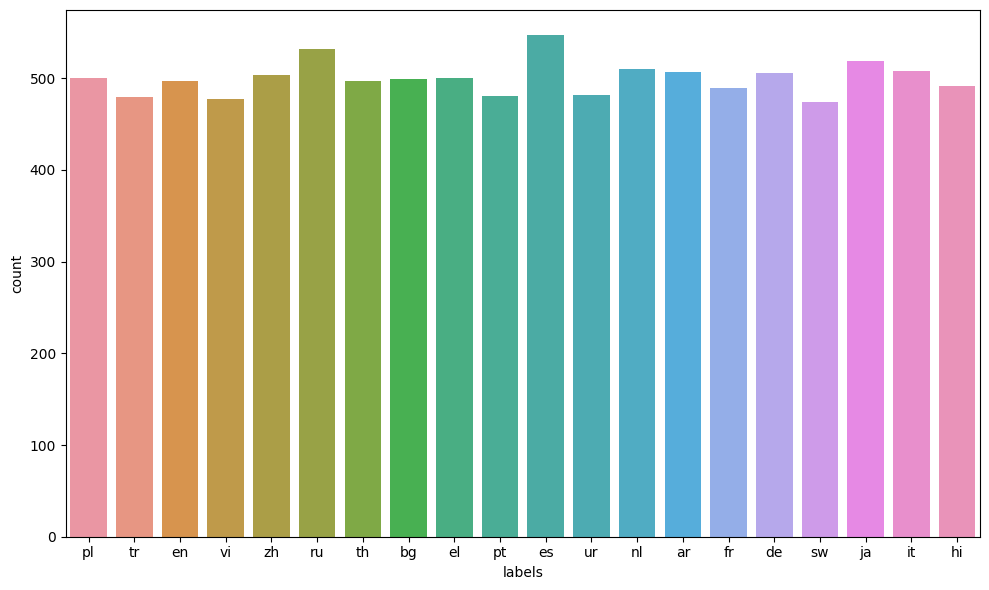

In [ ]:
sns.countplot(x=df['labels'])
plt.tight_layout();

#Text Preprocessing

In [ ]:
import re
import string
import emoji

import re
import string
import emoji

def preprocessing_text(text):
  # Biến đổi về chữ thường
  text = text.lower()
  # Loại bỏ biểu tượng
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  # Loại bỏ các dấu câu
  translator = str.maketrans('', '', string.punctuation)
  text = text.translate(translator)
  return text.strip()

preprocessing_text('Xin chào mọi người, tôi tên là Dũng. ')

'xin chào mọi người tôi tên là dũng'

In [ ]:
df['text'] = df['text'].apply(preprocessing_text)
df = df.rename(columns={'labels':'language'})
df.head()

,language,text
0,pl,mld wszyscy na świecie na obecnym poziomie do...
1,tr,bana mesaj var mı
2,en,i am allergic to cocoa and dairy and gluten fi...
3,tr,güçlü bir başarı oldu güç nesli nden gelen s...
4,vi,đối với tất cả sự vĩ đại lịch sử của nó thượn...


<Axes: xlabel='language', ylabel='count'>

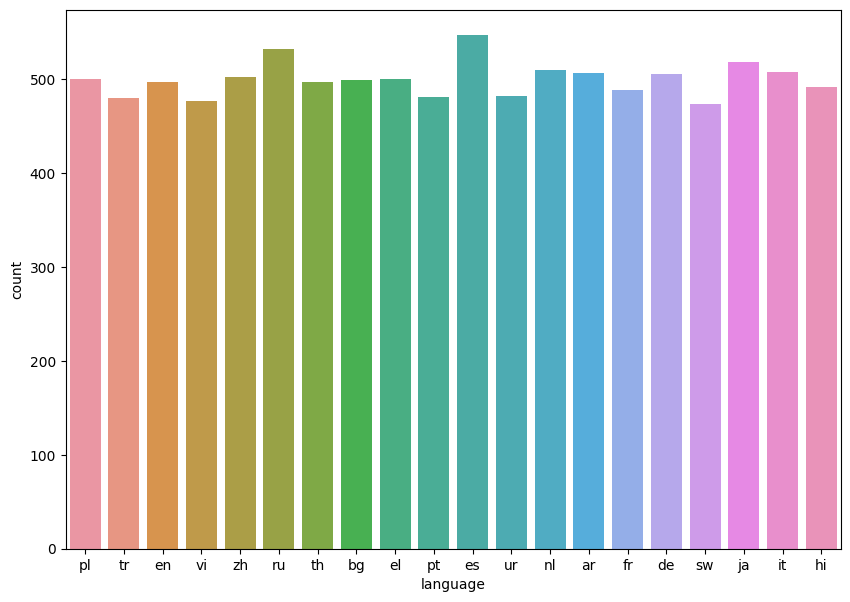

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot(x=df['language'])

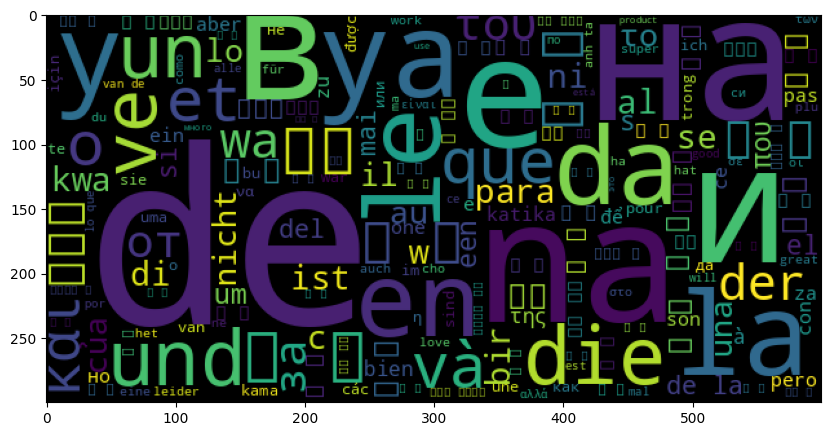

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(width=600,height=300,random_state=42).generate(' '.join(df.text))
plt.imshow(wc);

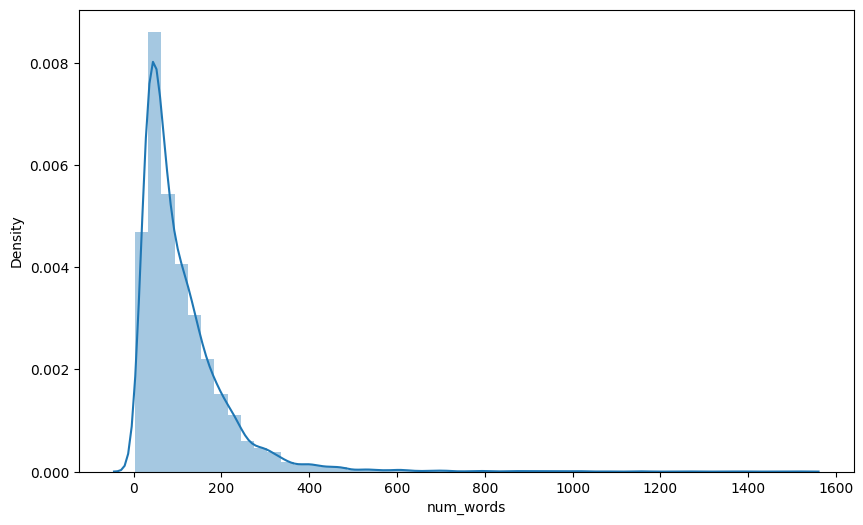

In [ ]:
df['num_words'] = df.text.apply(len)
sns.distplot(df.num_words);

In [ ]:
df.num_words.describe()

count    10000.000000
mean       109.072600
std         99.790041
min          3.000000
25%         45.000000
50%         80.000000
75%        142.000000
max       1513.000000
Name: num_words, dtype: float64

In [ ]:
max_len = int(np.percentile(df['num_words'], 95))
max_len

283

In [ ]:
max_len = 256

#Split data

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

len(train_df), len(val_df)

(9000, 1000)

# Encoding the target label classes

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.language.to_numpy())
val_labels_encoded = label_encoder.transform(val_df.language.to_numpy())

train_labels_encoded

array([13, 17,  1, ..., 18,  2,  3])

In [ ]:
class_names = label_encoder.classes_
num_classes = len(class_names)
num_classes, class_names

(20,
 array(['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'it', 'ja', 'nl',
        'pl', 'pt', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'], dtype=object))

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["language"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["language"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#Tạo hàm đánh giá các chỉ số

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def calculate_result(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accuracy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1-score': model_f1,
  }

  return model_results

#Model 0: Tạo mô hình cơ sở Tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_df.text.tolist(),
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0_preds = model_0.predict(val_df.text.tolist())
model_0_preds

array([10,  5,  5, 16, 10,  5, 17, 18,  9,  5,  4,  7,  5,  5, 11,  6,  4,
       10, 16, 17, 14, 12,  3, 16, 12,  3, 17, 14,  1,  7,  3,  2, 15, 17,
        8, 14,  1,  5,  5,  1, 18, 11, 18, 13, 14,  5,  5,  5, 15, 12,  5,
        7, 17,  5, 11,  7, 14, 12,  0,  6,  5,  2, 18, 17,  5, 18, 17, 16,
        6, 11, 13,  6,  2,  5,  4, 18,  7, 13,  5,  4, 14, 11, 13,  0, 17,
        6,  4,  5,  3,  4,  6, 15,  3, 10,  1, 18, 16,  5, 18,  8,  5,  5,
       13, 15,  8,  3,  4, 10,  5,  5, 13, 13,  8, 10,  8, 14,  1, 14, 10,
       15,  6, 14, 18,  3, 11,  0,  5, 16,  2,  0, 11,  7,  1, 14, 13,  8,
        1,  1, 11,  8,  5, 17,  0, 12, 16, 17,  7, 18, 10, 15, 10, 18, 11,
       10,  5,  8,  3,  5,  7, 14, 12,  5,  6, 17, 10, 16,  7,  7,  2,  8,
        4,  4, 15,  5,  6, 10,  5,  5, 17, 19, 13,  1, 12, 14,  7, 15, 13,
       17,  4, 12, 13,  7,  3,  8,  9,  3, 10,  1,  8,  1, 18,  0,  3,  3,
       15,  7,  8,  2,  1, 18, 10, 13,  3,  2, 16, 12, 16,  2,  7, 16,  5,
       11, 12,  0,  2, 10

In [ ]:
calculate_result(y_true=val_labels_encoded,
                 y_pred=model_0_preds)

{'accuracy': 0.89,
 'precision': 0.9537681755511569,
 'recall': 0.89,
 'f1-score': 0.8801781905989872}

In [ ]:
def plot_cm(cm):
  plt.figure(figsize=(9,6))
  df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
  ax = sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

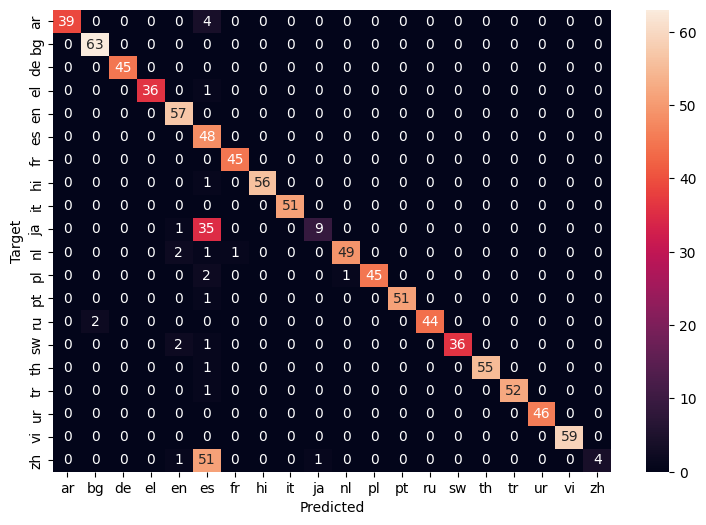

In [ ]:
cm = confusion_matrix(val_labels_encoded, model_0_preds)
plot_cm(cm)

In [ ]:
class_names[model_0.predict(['xin chào mọi người'])[0]]

'vi'

In [ ]:
class_names[model_0.predict(['私という人間'])[0]]

'es'

In [ ]:
class_names[model_0.predict(['кой съм аз'])[0]]

'bg'

#Chuyen du lieu sang datasets

In [ ]:
id2label = {k:v for k,v in enumerate(class_names)}
label2id = {v:k for k,v in id2label.items()}

df['labels'] = df['language'].apply(lambda x: label2id[x])
df.head()

,language,text,num_words,labels
0,pl,mld wszyscy na świecie na obecnym poziomie do...,63,11
1,tr,bana mesaj var mı,17,16
2,en,i am allergic to cocoa and dairy and gluten fi...,198,4
3,tr,güçlü bir başarı oldu güç nesli nden gelen s...,179,16
4,vi,đối với tất cả sự vĩ đại lịch sử của nó thượn...,209,18


In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['language', 'text', 'num_words', 'labels'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['language', 'text', 'num_words', 'labels'],
        num_rows: 1000
    })
})

#Model: sử dụng model từ hugging face

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

checkpoint_model = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint_model)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint_model, num_labels=num_classes, id2label=id2label, label2id=label2id)

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier', 'dropout_39', 'pre_classifier']
You should probably TRAIN this model on a down-stream ta

In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 134734080 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 135,340,052
Trainable params: 135,340,052
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['text'], max_length=max_len, padding=True, truncation=True)

In [ ]:
tokenized_datasets = dataset.map(tokenize_fn, batched=True, remove_columns=['language', 'text', 'num_words'])
tokenized_datasets

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [ ]:
batch_size = 16

train_ds = model.prepare_tf_dataset(
    tokenized_datasets['train'],
    shuffle=True,
    batch_size=batch_size,
)

val_ds = model.prepare_tf_dataset(
    tokenized_datasets['test'],
    shuffle=False,
    batch_size=batch_size,
)

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback

def compute_matrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=-1)
  accuracy = accuracy_score(labels, predictions)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
  return {
      'accuracy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1': model_f1,
  }

metric_callback = KerasMetricCallback(
    metric_fn=compute_matrics, eval_dataset=val_ds
)

In [ ]:
from transformers import create_optimizer

num_train_epochs = 3
num_train_steps = (len(tokenized_datasets['train']) // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="./tc_model_save/logs")

callbacks = [metric_callback, tensorboard_callback]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=16,
                    epochs=num_train_epochs,
                    callbacks=callbacks)

Epoch 1/3
562/562 [==============================] - 291s 507ms/step - loss: 0.0199 - val_loss: 0.0454 - accuracy: 0.9910 - precision: 0.9912 - recall: 0.9910 - f1: 0.9910
Epoch 2/3
562/562 [==============================] - 273s 485ms/step - loss: 0.0069 - val_loss: 0.0247 - accuracy: 0.9950 - precision: 0.9951 - recall: 0.9950 - f1: 0.9950
Epoch 3/3
562/562 [==============================] - 271s 482ms/step - loss: 0.0024 - val_loss: 0.0264 - accuracy: 0.9950 - precision: 0.9951 - recall: 0.9950 - f1: 0.9950


In [ ]:
!tensorboard dev upload --logdir ./tc_model_save/logs \
  --name "NER with transformers" \
  --description "Training results for NER with fine-tuning distilbert-base-uncased" \
  --one_shot

2023-04-05 12:36:08.090850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tc_model_save/logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   JJD-FJH-XZF



New experiment created. View your TensorBoard at: https://tensorboard.dev

In [ ]:
pred_probs = model.predict(val_ds)

63/63 [==============================] - 12s 139ms/step


In [ ]:
preds = np.argmax(pred_probs.logits, axis=-1)

In [ ]:
calculate_result(y_true=tokenized_datasets['test']['labels'],
                 y_pred=preds)

{'accuracy': 0.995,
 'precision': 0.9951001511715797,
 'recall': 0.995,
 'f1-score': 0.9950100004853426}

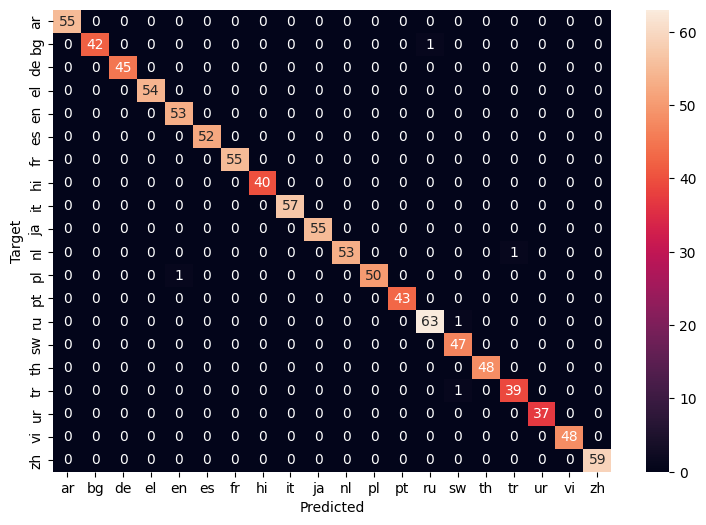

In [ ]:
cm = confusion_matrix(tokenized_datasets['test']['labels'], preds)
plot_cm(cm)

In [ ]:
  import pickle 
  save_path = 'language_indent_'
  model.save_pretrained(save_path)
  tokenizer.save_pretrained(save_path)

('language_indent_/tokenizer_config.json',
 'language_indent_/special_tokens_map.json',
 'language_indent_/vocab.txt',
 'language_indent_/added_tokens.json',
 'language_indent_/tokenizer.json')

In [ ]:
from transformers import pipeline

identor = pipeline('text-classification',
                   model=save_path,
                   tokenizer=save_path)

Some layers from the model checkpoint at language_indent_ were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at language_indent_ and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
identor("Tôi là ai, đây là đâu")

[{'label': 'vi', 'score': 0.9994947910308838}]

In [ ]:
identor("who am i and where is this")

[{'label': 'en', 'score': 0.9691397547721863}]

In [ ]:
identor("私は誰で、これはどこですか")

[{'label': 'ja', 'score': 0.9994924068450928}]

In [ ]:
identor("我是谁，这是哪里")

[{'label': 'zh', 'score': 0.99936443567276}]